# Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете

Необходимо по цифровым следам пользователя (на каких сайтах  он сидел, сколько раз заходил, какое у него устройство и тд) определить его пол и возраст. Данные взяты с соревнований MTS ML CUP (https://ods.ai/competitions/mtsmlcup).

Описание колонок файла с данными:

- 'region_name' – Регион

- 'city_name' – Населенный пункт

- 'cpe_manufacturer_name' – Производитель устройства

- 'cpe_model_name' – Модель устройства

- 'url_host' – Домен, с которого пришел рекламный запрос

- 'cpe_type_cd' – Тип устройства (смартфон или что-то другое)

- 'cpe_model_os_type' – Операционка на устройстве

- 'price' – Оценка цены устройства

- 'date' – Дата

- 'part_of_day' – Время дня (утро, вечер, итд)

- 'request_cnt' – Число запросов одного пользователя за время дня (поле part_of_day)

- 'user_id' – ID пользователя

Описание колонок файла с таргетами:

- 'age' – Возраст пользователя

- 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)

- 'user_id' – ID пользователя

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore");

PATH = '/MTS ML Cup/'
RAND = 42

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Прочтем файлы с данными

In [3]:
#данные
data = pd.read_parquet(PATH+'data.parquet', engine='fastparquet')
#id с разметкой (в виде справочника)
target = pd.read_parquet(PATH+'public_train.pqt', engine='fastparquet')

# Предварительный просмотр и анализ данных

Первые пять строк каждой из таблиц

**data**

In [4]:
data.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


In [5]:
data.shape

(32638709, 12)

**target**

In [6]:
target.head()

,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276
99002,41.0,0,99002
155506,33.0,0,155506
213873,54.0,0,213873


In [7]:
target.shape

(270000, 3)

Так как данных слишком много (для одного ноута), возьмем сэмпл (350 000 объектов) от исходной таблицы

In [8]:
data = data.sample(n=350000, random_state=RAND)

Типы данных каждого столбца

In [9]:
data.dtypes

region_name                      object
city_name                        object
cpe_manufacturer_name            object
cpe_model_name                   object
url_host                         object
cpe_type_cd                      object
cpe_model_os_type                object
price                           float64
date                     datetime64[ns]
part_of_day                      object
request_cnt                       int64
user_id                           int64
dtype: object

In [10]:
target.dtypes

age        float64
is_male     object
user_id      int64
dtype: object

Описание числовых признаков

In [11]:
data.describe()

,price,request_cnt,user_id
count,342741.000000,350000.000000,350000.000000
mean,33289.148380,1.727069,206509.437777
std,25919.499556,1.215198,119133.583248
min,90.000000,1.000000,4.000000
25%,13990.000000,1.000000,104517.000000
50%,21990.000000,1.000000,206718.500000
75%,50390.000000,2.000000,308739.000000
max,169990.000000,12.000000,415157.000000


In [12]:
target.describe()

,age,user_id
count,269999.000000,270000.000000
mean,38.789773,207547.794719
std,11.746168,119901.875310
min,0.000000,0.000000
25%,30.000000,103651.500000
50%,37.000000,207456.500000
75%,47.000000,311565.250000
max,91.000000,415313.000000


Описание категориальных признаков

In [13]:
data.describe(include='object')

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,part_of_day
count,350000,350000,350000,350000,350000,350000,350000,350000
unique,80,876,33,483,7457,4,3,4
top,Москва,Москва,Apple,iPhone 11,googleads.g.doubleclick.net,smartphone,Android,day
freq,51306,51306,135902,32265,23771,349917,214098,116667


In [14]:
target.describe(include='object')

,is_male
count,269958
unique,3
top,1
freq,135332


Количество пропусков по столбцам

In [15]:
data.isna().sum()

region_name                 0
city_name                   0
cpe_manufacturer_name       0
cpe_model_name              0
url_host                    0
cpe_type_cd                 0
cpe_model_os_type           0
price                    7259
date                        0
part_of_day                 0
request_cnt                 0
user_id                     0
dtype: int64

In [16]:
target.isna().sum()

age         1
is_male    42
user_id     0
dtype: int64

Количество явных дубликатов

In [17]:
data.duplicated().sum()

0

In [107]:
target.duplicated().sum()

0

**Вывод:** Имеется большое количество уникальных значений в некоторых категориальных признаках: город (***city_name***) и модель телефона (***cpe_model_name***). Возможно, для некоторых уникальных значений в этих признаках имеется не так много объектов в датасете. Например, какой-нибудь редкой модели телефона в выборке соответстует только один объект (та же ситуация с каким-нибудь очень маленьким городом). Поэтому имеет смысл поставить ограничение на минимальное количество объектов для каждого уникального значения в этих двух признаках.

В наших данных имеется 7259 пропуска в признаке ***price*** и небольшое количество пропусков в таблице *target*.

В таблице *target* в признаке ***age*** довольно странное минимальное значение, равное 0. Также, признак ***is_male*** имеет тип object, хотя по идее у нас всего два значения: 0 и 1.

# Предобработка данных

## Обработка пропусков

Пропуски присутствуют только в столбце ***price*** (оценка цены устройства). На цену устройства могут повлиять 2 признака: непосредственно какая модель устройства и год (так как с течением времени устройства дешевеют). Поэтому поступим следующим образом: для каждой модели устройства будем заполнять пропуски средним значением в разрезе года.

In [18]:
for year in data.date.dt.year.unique():
    for model in data.cpe_model_name.unique():
        value = data[(data.cpe_model_name==model)&(data.date.dt.year==year)].price.mean()
        
        data[(data.cpe_model_name==model)&(data.date.dt.year==year)] = \
        data[(data.cpe_model_name==model)&(data.date.dt.year==year)].fillna(value)
        

Посмотрим, как изменилось количество пропусков

In [19]:
data.isna().sum()

region_name                 0
city_name                   0
cpe_manufacturer_name       0
cpe_model_name              0
url_host                    0
cpe_type_cd                 0
cpe_model_os_type           0
price                    3958
date                        0
part_of_day                 0
request_cnt                 0
user_id                     0
dtype: int64

Почти половина пропусков ликвидирована, остальные дропнем, так как они составляют мизерную часть от всего датасета (1%). По той же причине избавимся от пропусков в таблице *target* аналогичным способом.

In [20]:
data = data.dropna()
target = target.dropna()

## Целевые переменные

### *age*

Посмотрим на процент нулевых значений в целевой переменной ***age***

In [21]:
target[target.age==0].age.count() / target.shape[0]

0.00010742451575621303

Этот процент ничтожно мал, поэтому дропнем эти нули

In [22]:
target = target.drop(target[target.age==0].index)

Теперь еще раз посмотрим на описание столбцов

In [23]:
target.describe()

,age,user_id
count,269928.000000,269928.000000
mean,38.797487,207545.297972
std,11.737385,119903.373959
min,14.000000,0.000000
25%,30.000000,103648.750000
50%,37.000000,207452.000000
75%,47.000000,311563.500000
max,91.000000,415313.000000


Такая картина уже более реальная. Действительно, смартфоны появляются у подростков примерно в 14 лет (конечно, бывает и раньше). Что касается максимального возраста в 91 год, то тоже несложно представить продвинутую бабушку, отправляющую бесчисленное множество открыток в WhatsApp и смотрящую прогноз погоды, советы для огородников и тд.

### *is_male*

Как упоминалось ранее, по какой-то причине столбец ***is_male*** имеет тип object. Посмотрим на уникальные значения данного столбца.

In [24]:
target.is_male.value_counts()

1     135314
0     128982
NA      5632
Name: is_male, dtype: int64

Действительно, присутствует небольшой процент выбросов (2%) со значением NA, от которых можем избавиться. Также, переведем тип данной колонки в int. 

In [25]:
target = target.drop(target[target.is_male=='NA'].index)
target.is_male = target.is_male.astype('int64')

## Объединение таблиц *data* и *target*

Для удобства объединим таблицы с признаками и таргетами

In [28]:
data = data.merge(target, on='user_id')

## Ограничение на минимальное количество объектов для каждого уникального значения в признаках ***city_name*** и ***cpe_model_name***

Рассмотрим для примера количество пользователей в каждом городе в одном из регионов

Напишем вспомогательную функцию для визуального отбражения

In [29]:
def plot(col1: str, col2: str, col3: str):
    pivot = data.pivot_table(index=[col1, col2],
                             values='user_id', 
                             aggfunc='count').reset_index()

    fig = plt.figure(figsize=(10, 15))

    sns.barplot(data=pivot[pivot[col1]==col3].
                     sort_values(by='user_id', ascending=False),
                x='user_id',
                y=col2, 
                palette='mako')

    plt.xlabel('Количество пользователей', fontsize=14)
    plt.ylabel('', fontsize=14);

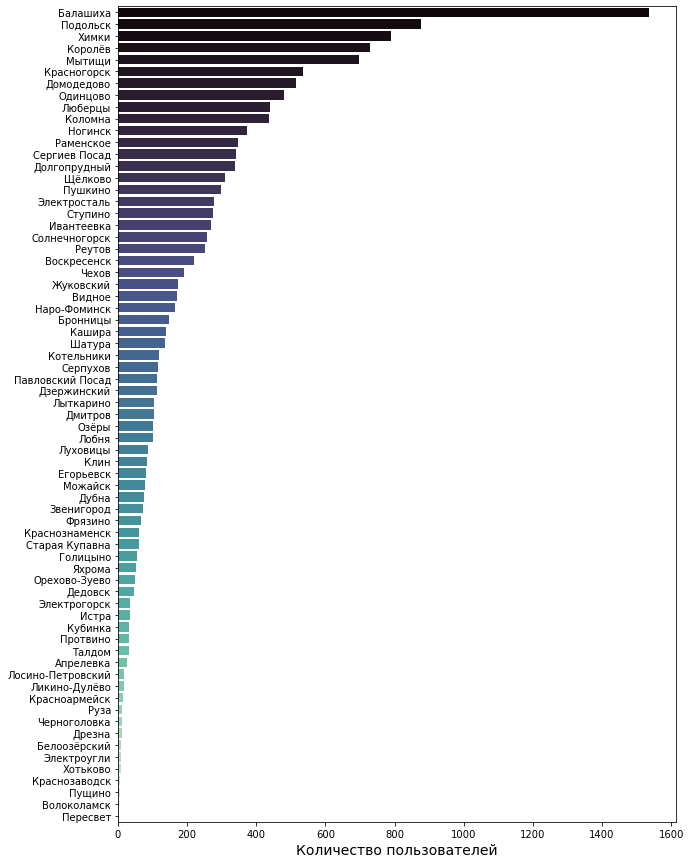

In [30]:
plot('region_name', 'city_name', 'Московская область')

Аналогичным образом посмотрим на количество пользователей для каждой модели телефона одного из производителей

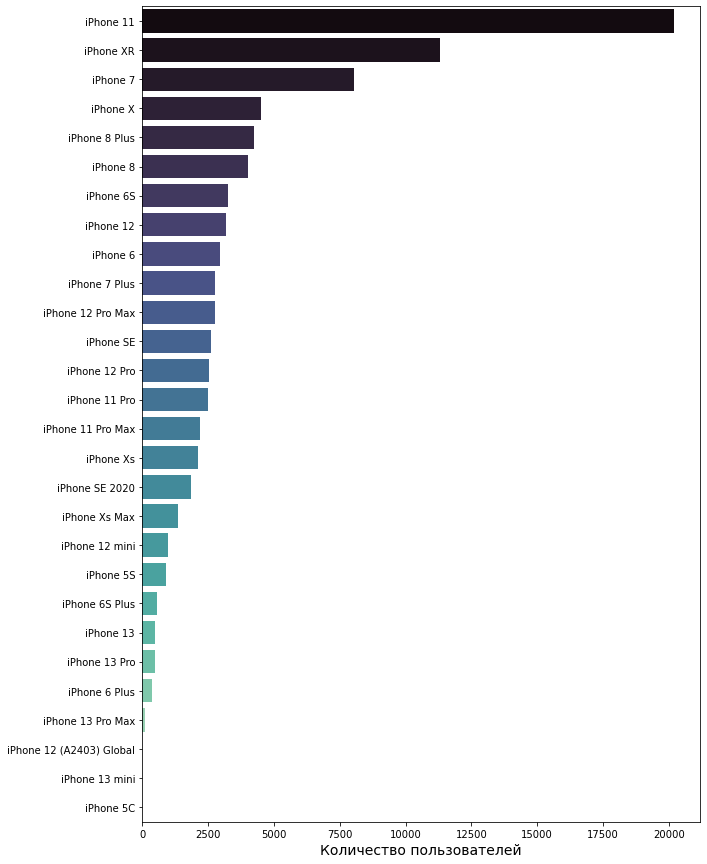

In [31]:
plot('cpe_manufacturer_name', 'cpe_model_name', 'Apple')

Как видно из графиков, действительно для некоторых городов и моделей телефонов слишком мало объектов в датасете. Поэтому поставим ограничение на минимальное количество объектов для каждого уникального значения в этих двух признаках (возьмем 250)

Для начала напишем вспомогательную функцию, которая будет создавать колонку в таблице, отображающую общее количество объектов, которое соответствуюет определенному значению поданного на вход признака 

In [108]:
def counter(col: str) -> pd.DataFrame:
    pivot = data[col].value_counts().reset_index() \
    .rename({'index': col, col: 'count_'+col}, axis=1)
    
    return data.merge(pivot, on=col)

Применим функцию

In [33]:
data = counter('city_name')
data = counter('cpe_model_name')

In [34]:
data.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male,count_city_name,count_cpe_model_name
0,Краснодарский край,Геленджик,Apple,iPhone X,instagram.com,smartphone,iOS,67590.0,2021-06-29,day,2,214519,29.0,0,443,4519
1,Краснодарский край,Геленджик,Apple,iPhone X,instagram.com,smartphone,iOS,67590.0,2021-06-29,evening,6,214519,29.0,0,443,4519
2,Краснодарский край,Геленджик,Apple,iPhone X,googleads.g.doubleclick.net,smartphone,iOS,76665.0,2021-07-19,day,3,60193,31.0,1,443,4519
3,Краснодарский край,Геленджик,Apple,iPhone X,vk.com,smartphone,iOS,73374.0,2021-07-28,day,1,319852,28.0,0,443,4519
4,Краснодарский край,Геленджик,Apple,iPhone X,tpc.googlesyndication.com,smartphone,iOS,73374.0,2021-07-24,morning,1,319852,28.0,0,443,4519


Теперь можем избавиться от ненужных объектов

In [35]:
data = data[(data.count_city_name>=250)&(data.count_cpe_model_name>=250)]

Удалим созданные вспомогательные признаки

In [36]:
data = data.drop(['count_city_name', 'count_cpe_model_name'], axis=1)

# EDA

## Целевые переменные

Для начала посмотрим на распределение таргетов. Рассмотрим ***is_male***.

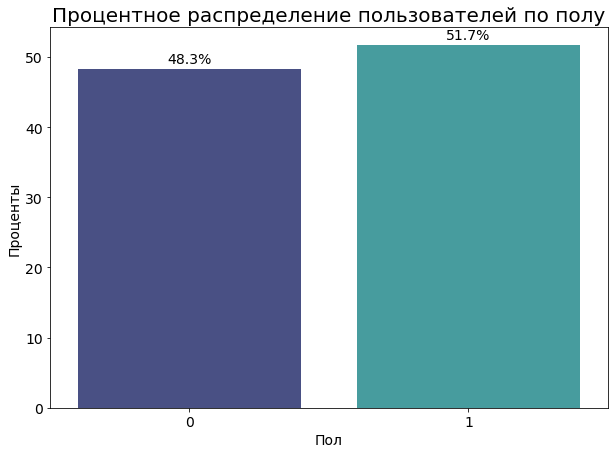

In [37]:
gender_values = (data.is_male
                     .value_counts(normalize=True)
                     .mul(100)
                     .rename('percent')
                     .reset_index()) 

fig = plt.figure(figsize=(10, 7))

ax = sns.barplot(x='index',
                 y='percent',
                 data=gender_values,
                 palette='mako')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14)
    
plt.title('Процентное распределение пользователей по полу', fontsize=20)

plt.xlabel('Пол', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** дисбаланса классов не наблюдается

Теперь посмотрим на распределение возраста (***age***)

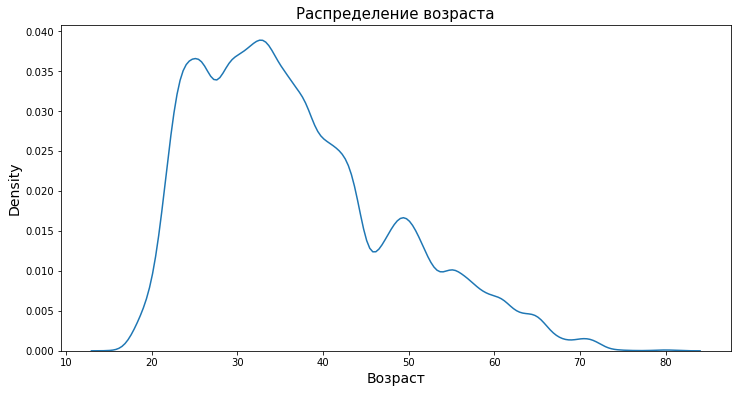

In [38]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data=data.age)

plt.title('Распределение возраста', fontsize=15)

plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** как видно из графика, бОльшую часть пользователей составляют люди в возрасте от 24 до 40 лет.

Посмотрим на распределение возраста в разрезе пола

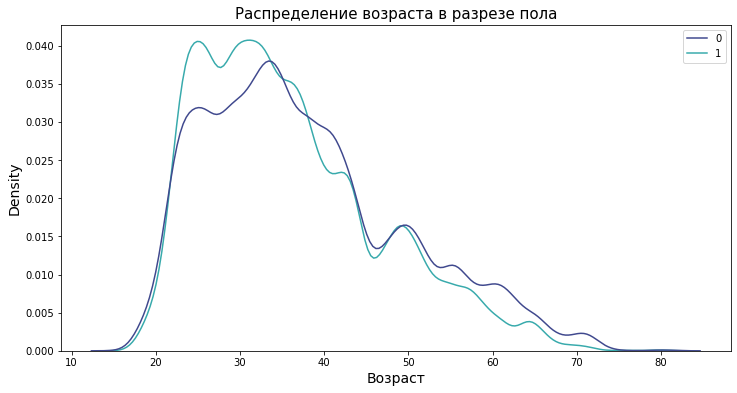

In [62]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  '0': data[data.is_male==0].age,
                  '1': data[data.is_male==1].age
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение возраста в разрезе пола', fontsize=15)

plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** характеры распределений возраста у мужчин и женщин практически идентичны

## Влияние различных признаков на целевые переменные

## Время дня

### Процентное распределение количества пользователей в зависимости от времени дня в разрезе пола

Создадим функцию для построения вспомогательной сводной таблицы для построения требуемого графика

In [112]:
def pivot(column: str) -> pd.DataFrame:
    pivot = data.pivot_table(index=['is_male',column],
                             values='user_id',
                             aggfunc='count').reset_index()
    pivot_1 = pivot.groupby('is_male').sum('user_id').reset_index().rename(columns={'user_id': 'sum_gender'})
    pivot = pivot.merge(pivot_1, on='is_male')
    pivot['percent'] = (pivot['user_id'] / pivot['sum_gender']) * 100
    
    return pivot.sort_values('percent', ascending=False)

Построим график

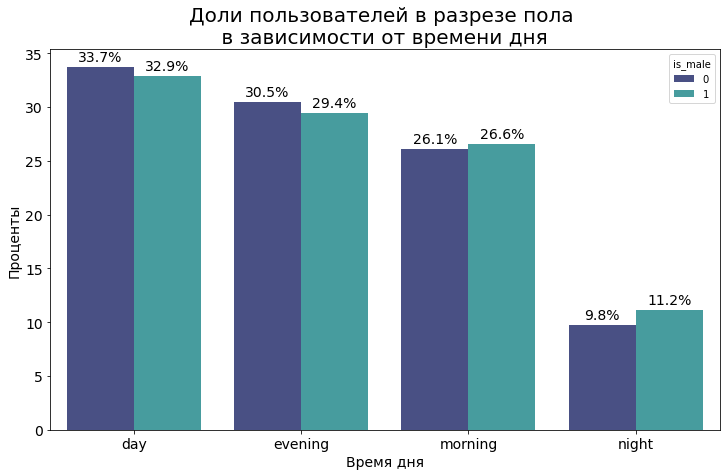

In [41]:
fig = plt.figure(figsize=(12,7))

ax = sns.barplot(x='part_of_day',
                 y='percent',
                 data=pivot('part_of_day'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от времени дня ', fontsize=20)

plt.xlabel('Время дня', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


**Вывод:** Чаще всего пользователи выходят в сеть днем, чуть реже вечером и утром. Ночью, как правило, люди спят, отсюда и небольшое число пользователей, выходивших в сеть в сравнении с отсальными временами дня. Стоит отметить, что днем и вечером чаще выходят в сеть женщины, а утром и ночью мужчины.

### Распределение возраста в разрезе времени дня 

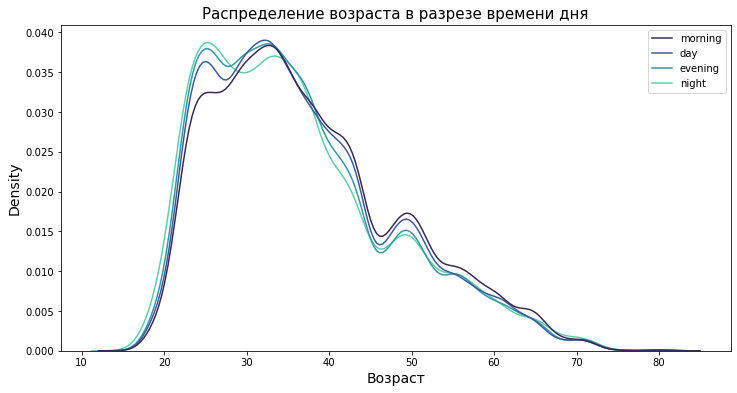

In [63]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  'morning': data[data.part_of_day=='morning'].age,
                  'day': data[data.part_of_day=='day'].age,
                  'evening': data[data.part_of_day=='evening'].age,
                  'night': data[data.part_of_day=='night'].age
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение возраста в разрезе времени дня', fontsize=15)

plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** Молодые люди в возрасте около 23 лет чаще выходят в сеть ночью и вечером, и заметно реже утром. Пользователи среднего возраста (35-40 лет) на протижении всего дня выходят в сеть примерно одинаково, чкть реже ночью. Ну а более возрастные пользователи (около 50 лет) заметно чаще пользуются интернетом в первую половину дня, преимущественно утром.

## Производитель устройства

### Процентное распределение количества пользователей в зависимости от производителя устройства в разрезе пола

Для удобства построения графика заменим некторые значения признака ***cpe_manufacturer_name*** на более короткие

In [43]:
data.cpe_manufacturer_name = data.cpe_manufacturer_name \
                                 .replace({'Realme Chongqing Mobile Telecommunications Corp Ltd': 'Realme',
                                           'Huawei Device Company Limited': 'Huawei'})

Построим график

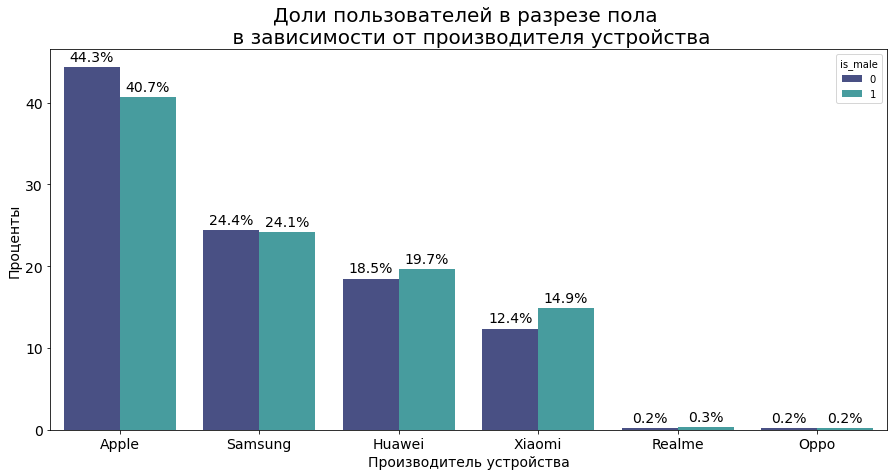

In [44]:
fig = plt.figure(figsize=(15,7))

ax = sns.barplot(x='cpe_manufacturer_name',
                 y='percent',
                 data=pivot('cpe_manufacturer_name'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от производителя устройства', fontsize=20)

plt.xlabel('Производитель устройства', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** Лидирующим брендом по количеству пользователей является Apple. Дальше идут Samsung, Huawei и Xiaomi. Пользователей с устройствами других производителей значительно меньше. При этом среди пользователей Apple и Samsung больше женщин, а среди пользователей остальных производителей больше мужчин.

### Распределение возраста в разрезе производителя устройства

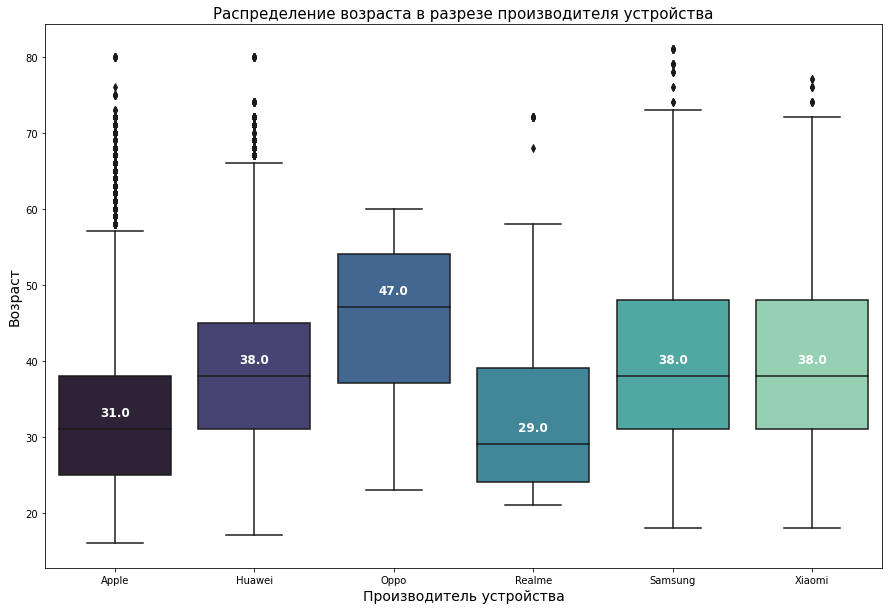

In [96]:
fig = plt.figure(figsize=(15,10))

box_plot = sns.boxplot(x='cpe_manufacturer_name',
                       y='age',
                       data=data.sort_values(by='cpe_manufacturer_name'),
                       palette='mako')

medians = data.groupby(['cpe_manufacturer_name'])['age'].median()
vertical_offset = data['age'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='large',color='w',weight='semibold')

plt.title('Распределение возраста в разрезе производителя устройства', fontsize=15)

plt.xlabel('Производитель устройства', fontsize=14)
plt.ylabel('Возраст', fontsize=14);


**Вывод:** У Apple и Realme наименьшие медианные возраста (около 30 лет). Samsung, Huawei и Xiaomi в основном по душе пользователям в возрасте ближе к 40 годам, а любителям девайсов от Oppo по большей части около 47-50 лет. При этом у для Apple, Samsung, Huawei и Xiaomi разброс возраста достаточно велик, а для Realme и Oppo заметно меньше.

## Регион

### Процентное распределение количества пользователей в зависимости от региона в разрезе пола

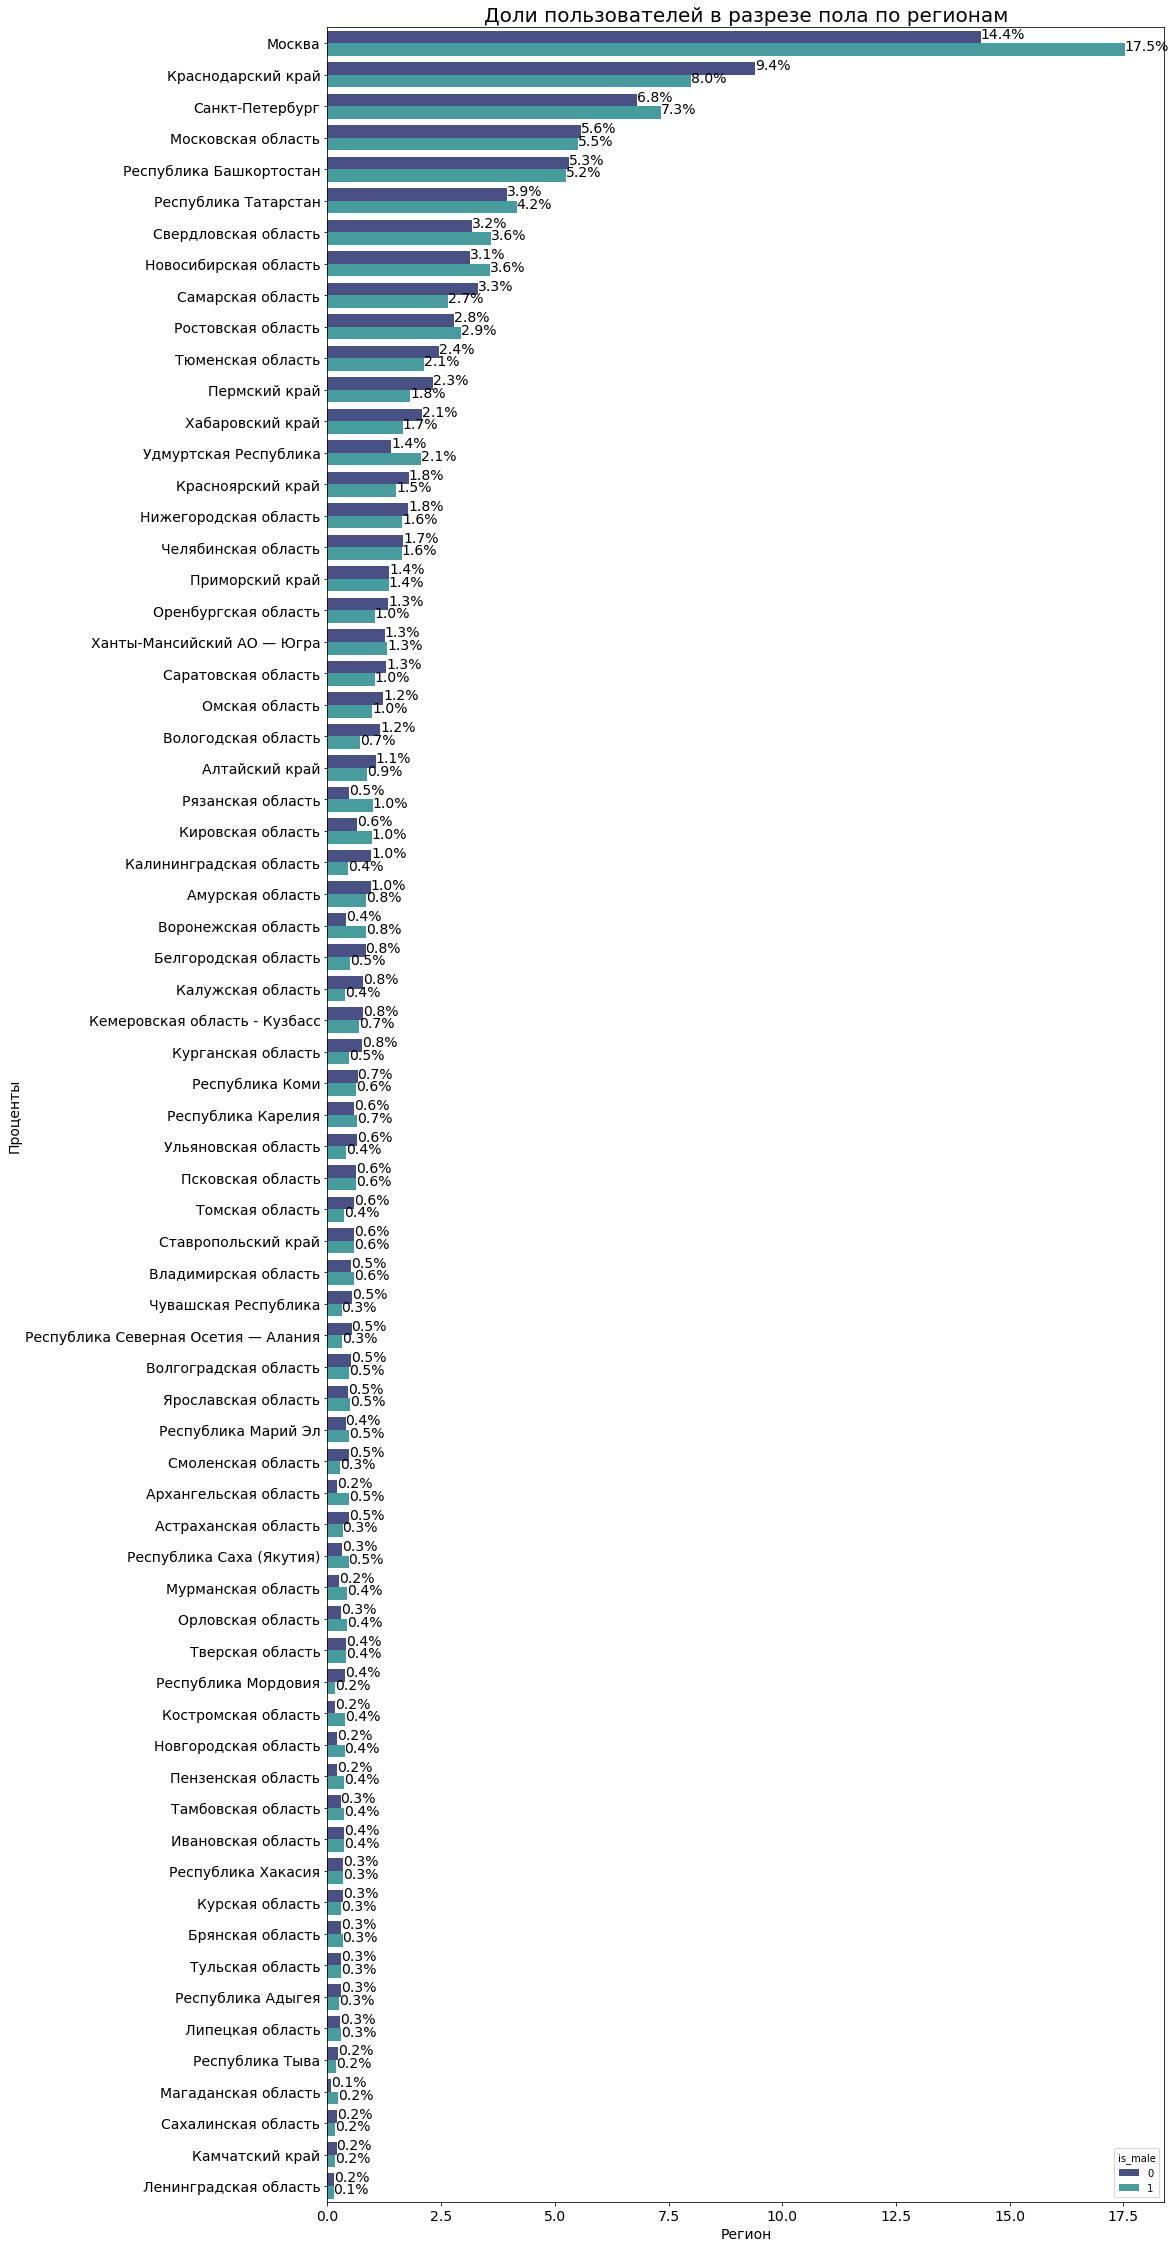

In [46]:
fig = plt.figure(figsize=(15,40))

ax = sns.barplot(x='percent',
                 y='region_name',
                 data=pivot('region_name'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    ax.annotate(percentage, 
                (p.get_width() , p.get_y() + p.get_height() / 2.), 
                ha='left', 
                va='top',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола по регионам', fontsize=20)

plt.xlabel('Регион', fontsize=14)
plt.ylabel('Проценты', fontsize=14)
plt.legend(loc='lower right', title='is_male')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** По графику видно, что соотношение количества мужчин и женщин среди пользователей меняется в зависимости от региона. Например, в Москве заметно больше мужчин, а в Краснодарском крае среди пользователей преобладают женщины. В то же время имеются регионы, в которых мужчин и женщин практически поровну.

### Распределение возраста в разрезе региона

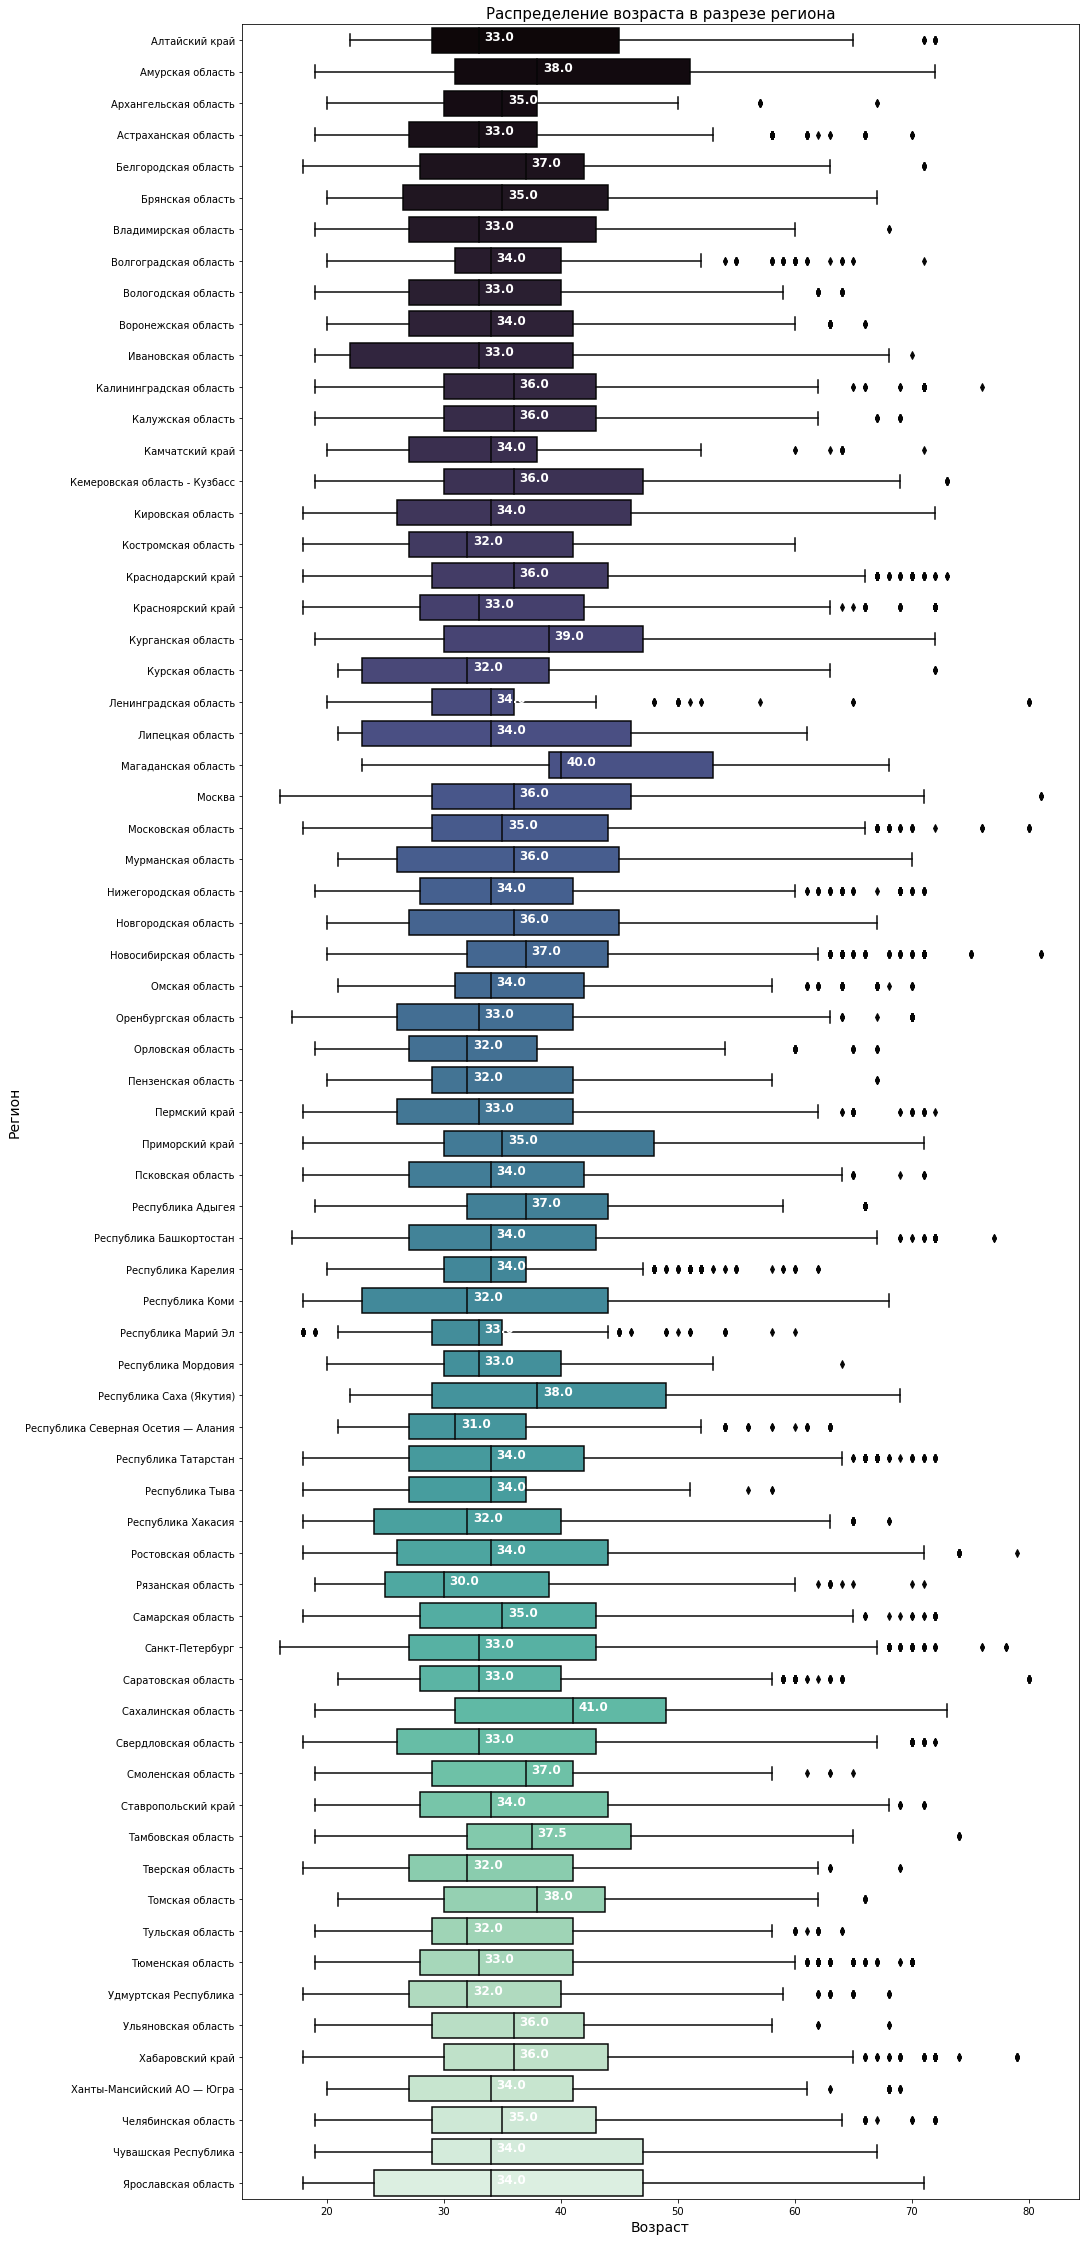

In [47]:
fig = plt.figure(figsize=(15,40))

box_plot = sns.boxplot(x='age',
                       y='region_name',
                       data=data.sort_values(by='region_name'),  #sort_values необходим для 
                       palette='mako')                           #корректного отображения медиан


medians = data.groupby(['region_name'])['age'].median()
vertical_offset = data['age'].median() * 0.05 # offset from median for display

for ytick in box_plot.get_yticks():
    box_plot.text(medians[ytick]+vertical_offset,ytick,medians[ytick], 
            horizontalalignment='center',size='large',color='w',weight='semibold')
    
plt.title('Распределение возраста в разрезе региона', fontsize=15)

plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Регион', fontsize=14);

**Вывод:** Медианный возраст меняется от региона к региону. Самый большой медианный возраст в Сахалинской области (41 год), а самый маленький - в Рязанской области. Разброс значений достаточно большой абсолютно во всех регионах.

## Операционная система на устройстве

### Процентное распределение количества пользователей в зависимости от операционной системы на устройстве в разрезе пола

В признаке ***cpe_model_os_type*** 3 уникальных значения: Android, iOS и Apple iOS. Очевидно, что последние два это одно и то же.

In [48]:
data.cpe_model_os_type = data.cpe_model_os_type.replace({'Apple iOS': 'iOS'})

Теперь построим график

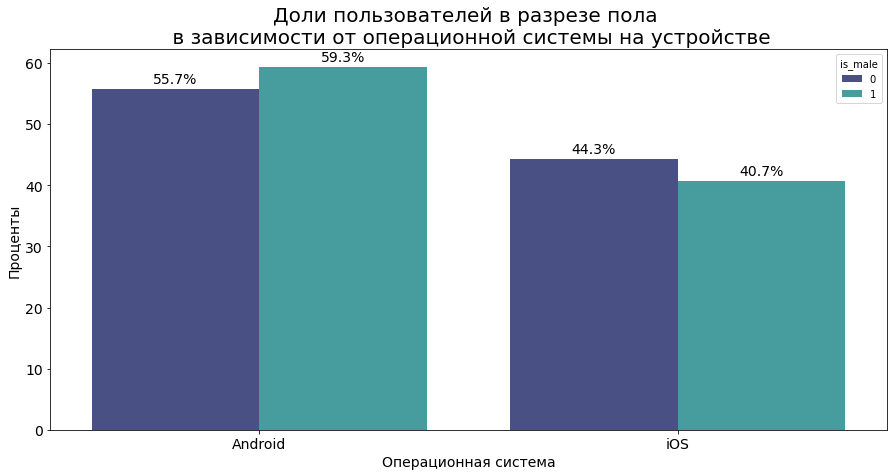

In [65]:
fig = plt.figure(figsize=(15,7))

ax = sns.barplot(x='cpe_model_os_type',
                 y='percent',
                 data=pivot('cpe_model_os_type'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от операционной системы на устройстве', fontsize=20)

plt.xlabel('Операционная система', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** Процент пользователей Android больше, чем у iOS (пользователей Apple больше, чем у других производителей по отдельности, но не в сумме). При этом Android больше предпочитают мужчины, а iOS женщины.

### Распределение возраста в разрезе операционной системы

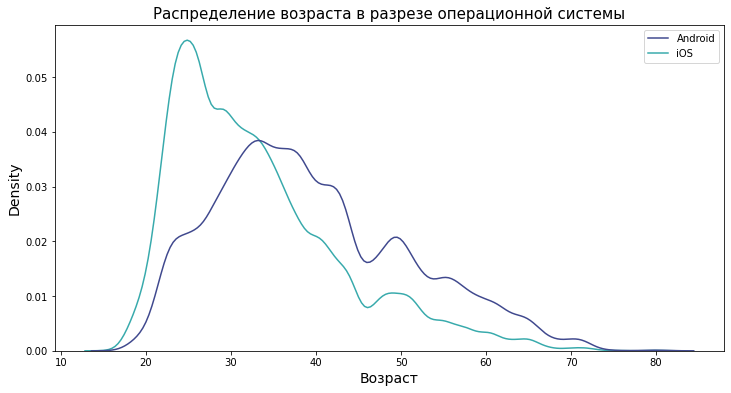

In [66]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  'Android': data[data.cpe_model_os_type=='Android'].age,
                  'iOS': data[data.cpe_model_os_type=='iOS'].age,
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение возраста в разрезе операционной системы', fontsize=15)

plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** Среди пользователей iOS по количеству преобладают молодые люди в возрасте около 25 лет, в то время как любителям Android в основной массе от 33 до 40 лет.

## Оценка цены устройства

### Распределение цены устройства в разрезе пола

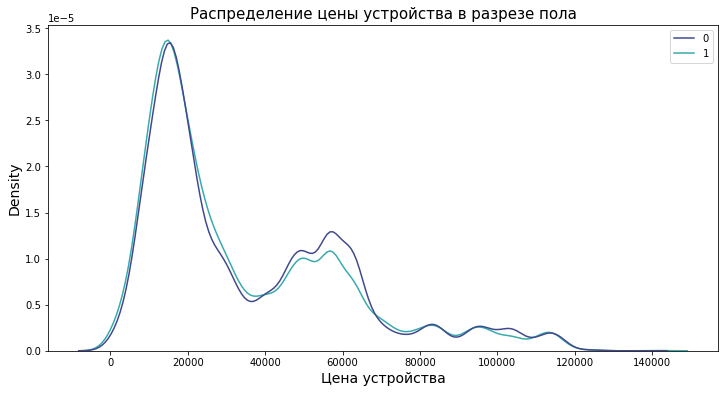

In [81]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  '0': data[data.is_male==0].price,
                  '1': data[data.is_male==1].price,
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение цены устройства в разрезе пола', fontsize=15)

plt.xlabel('Цена устройства', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** характеры распределений цены устройства в разрезе пола практически идентичны

### Распределение возраста в зависимости от цены устройства 

Так как ***price*** числовой признак, то для удобства анализа зависимости возраста от цены устройства  создадим дополнительную колонку с возрастными категориями

In [98]:
def age_bins(age):
    if 15<=age<20:
        return '15-19'
    elif 20<=age<26:
        return '20-25'
    elif 26<=age<36:
        return '26-35'
    elif 36<=age<46:
        return '36-45'
    elif 46<=age<56:
        return '46-55'
    elif 56<=age<66:
        return '56-65'
    elif age>65:
        return '66+'
        
data['age_bins'] = data.age.apply(age_bins)    

Построим график

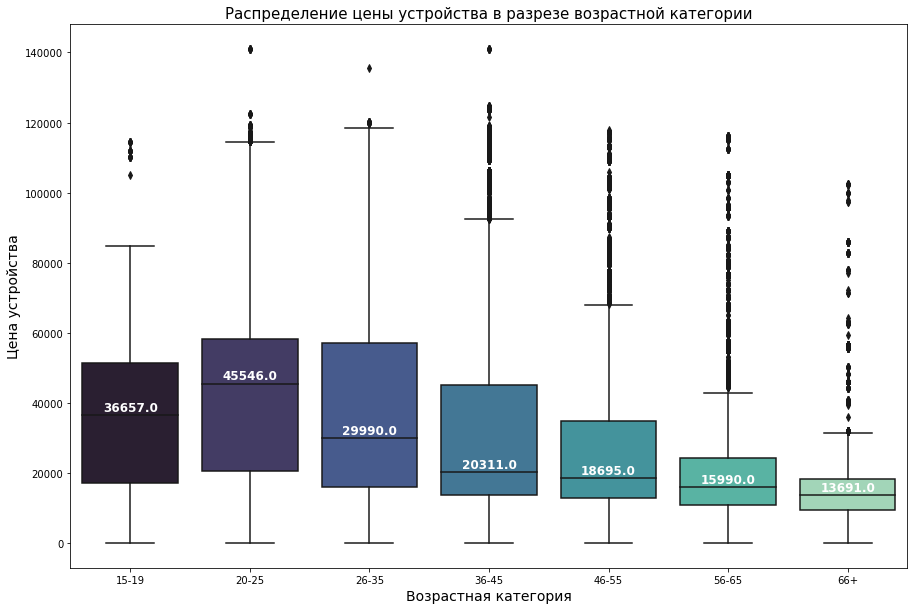

In [105]:
fig = plt.figure(figsize=(15,10))

box_plot= sns.boxplot(x='age_bins',
                      y='price',
                      data=data,
                      palette='mako', 
                      order=['15-19', '20-25', '26-35', '36-45', '46-55', '56-65', '66+'])

medians = data.groupby(['age_bins'])['price'].median()
vertical_offset = data['price'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='large',color='w',weight='semibold')

plt.title('Распределение цены устройства в разрезе возрастной категории', fontsize=15)

plt.xlabel('Возрастная категория', fontsize=14)
plt.ylabel('Цена устройства', fontsize=14);

**Вывод:** Самые дорогие устройства у пользователей в возрасте 20-25 лет с медианной ценой устройства, равной около 45-46к. Устройства с наимешьшей ценой (медиана 13.7к) принадлежит пользователям возрастной категории 66+. Стоит отметить, что наблюдается некая тенденция - с увеличением возрастной категории (если опустить категорию подростков 15-19 лет) медианная цена устройства падает. 

## Число запросов одного пользователя за время дня

### Распределение числа запросов одного пользователя за время дня в разрезе пола

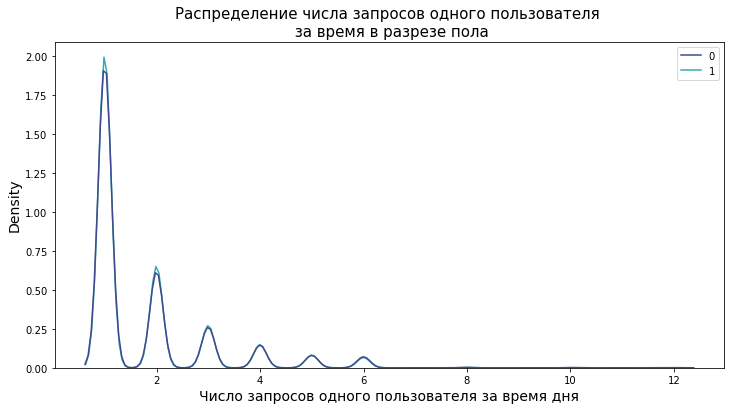

In [115]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  '0': data[data.is_male==0].request_cnt,
                  '1': data[data.is_male==1].request_cnt,
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение числа запросов одного пользователя \n за время в разрезе пола', fontsize=15)

plt.xlabel('Число запросов одного пользователя за время дня', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** признак ***request_cnt*** никак не влияет на пол пользователя

### Распределение возраста в зависимости от числа запросов одного пользователя за время дня

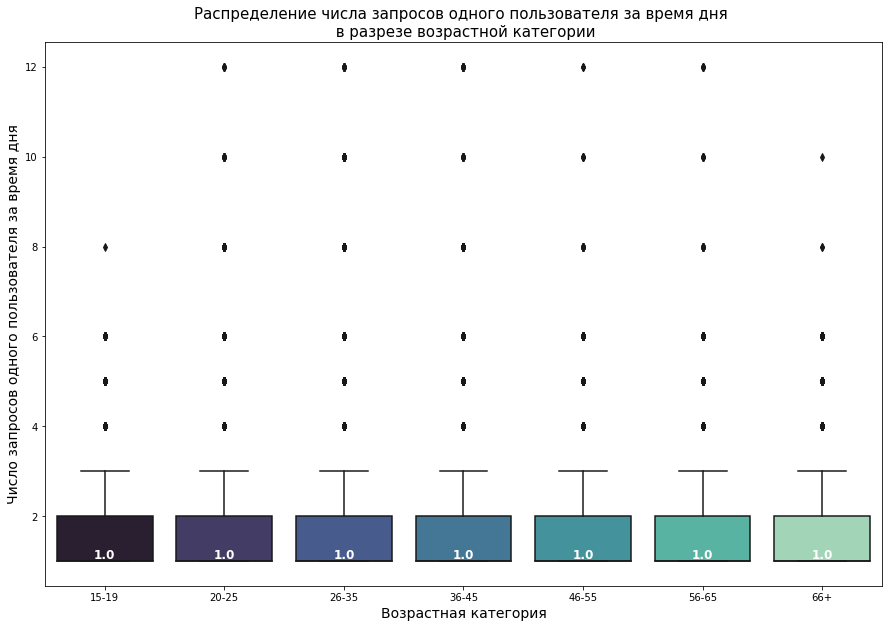

In [118]:
fig = plt.figure(figsize=(15,10))

box_plot= sns.boxplot(x='age_bins',
                      y='request_cnt',
                      data=data,
                      palette='mako', 
                      order=['15-19', '20-25', '26-35', '36-45', '46-55', '56-65', '66+'])

medians = data.groupby(['age_bins'])['request_cnt'].median()
vertical_offset = data['request_cnt'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='large',color='w',weight='semibold')

plt.title('Распределение числа запросов одного пользователя за время дня \n в разрезе возрастной категории', fontsize=15)

plt.xlabel('Возрастная категория', fontsize=14)
plt.ylabel('Число запросов одного пользователя за время дня', fontsize=14);

**Вывод:** как и в случае с полом, на возраст так же число запросов одного пользователя за время дня никак не влияет

# Заключение

Все рассмотренные признаки **по отдельности** (кроме ***request_cnt***) в той или иной мере влияют на целевые переменные - возраст и пол пользователя. Так же стоит отметить, что в исходных данных было несколько уникальных значений в признаке ***cpe_type_cd*** (тип устройства). Но 99% составляли смартфоны, поэтому после предобработки (удаление пропусков и тд) в данном столбце остались только смартфоны.

In [120]:
data.cpe_type_cd.value_counts()

smartphone    172942
Name: cpe_type_cd, dtype: int64

Смысла от такого признака нет, поэтому удалим данный столбец (а также age_bins, тк он был вспомогательным для построения графиков)

In [127]:
data = data.drop(['cpe_type_cd', 'age_bins'], axis=1)

Сохраним эту таблицу в отдельный csv файл для дальнейшей работы (построение моделей)

In [133]:
data.to_csv(PATH+'data_cleaned.csv', index=False)